# Technical Assessment

## Overview

- **Author:**
    - Alex Sandro Alves de Araujo (alex.fate2000@gmail.com).
- **Programming Language:**
    - Python 3.
- **Data Set:**
    - Selected data set in Kaggle is [Credit Card Fraud Detection, Anonymized credit card transactions labeled as fraudulent or genuine](https://www.kaggle.com/mlg-ulb/creditcardfraud).
- **Exploratory Data Analysis:**
    - Total of **30** features and **284807** instances. 
    - Most features come from principal components obtained by means of PCA (**V1**, **V2**, ..., **V28**), along with two other original ones: **Time** and **Amount**. 
    - Data show a small number of duplicated instances: **1081** (**~0.38%**).
    - Highly unbalanced data set: **~99.83%** are genuine transactions and **~0.17%** are fraudulent ones. 
    - **V11**, **V10**, **V12**, **V14**, and **V17** they have the highest univariate dependencies with the target, as estimated from mutual information. 
    - Non-Gaussian features. 
    - Create date time index **assuming** first time step at **00h00min00sec** in day **2013-09-01**.
    - The entire data set correspond to **two** days of transactions.
    - Valid transactions have a regular pattern along these two days, that is, a high flat number of transactions in daytime and higher total amount spent at lunch time and then followed by afternoon coffee.
    - Fraudulent transactions occur irregularly over the days, but two episodes draw attention, one at **11 am** in the first day and another at **2 am** in the second day.
    - Due to the size of the available data, which make up just two complete days of transactions, we decided to address the problem without taking into account the temporal ordering of the target and features.    
- **Data Split:**
    - Stratified random train-validation (**80%**) and test (**20%**) subsets.    
- **Dummy Classifier:**
    - A simple benchmark classifier that votes for most frequent class in training set. 
- **Logistic Regression:**
    - Use all available features.
    - Exhaustive hyper parameter search with stratified **5-fold** cross validation using Matthews correlation coefficient for scoring.
    - Preprocessing steps in the pipeline: (1) Robust Scaler and (2) Yeo-Johnson Power Transform.    
    - Search for best hyperparameter for inverse of regularization strength among 100 candidates (**C**).
    - Most of the results for permutation feature importance were as expected, given the previous estimated mutual information between each feature and the target.
- **Decision Tree:**
    - Use all available features.
    - Exhaustive hyper parameter search with stratified **5-fold** cross validation using Matthews correlation coefficient for scoring.
    - Without preprocessing steps in the pipeline.    
    - Search for the best hyperparameter set among 112 candidates, varying the function to measure the quality of a split (**criterion**), the strategy used to choose the split at each node (**splitter**), maximum depth of the tree (**max_depth**), and the number of features to consider when looking for the best split (**max_features**).
    - Most of the results for permutation feature importance were as expected, given the previous estimated mutual information between each feature and the target.
- **XGBoost Classifier:**
    - Use the **9** most important features according to the previous decision tree model: **V26**, **V27**, **V21**, **V8**, **V7**, **V16**, **V17**, **V10**, and **V14**
    - Exhaustive hyper parameter search with stratified **5-fold** cross validation using Matthews correlation coefficient for scoring.
    - Without preprocessing steps in the pipeline.    
    - Search for the best hyperparameter set among **32** candidates, varying the number of boosting rounds (**n_estimators**), balancing of positive and negative weights (**scale_pos_weight**), boosting learning rate (**learning_rate**), L1 regularization term on weights (**reg_alpha**), and L2 regularization term on weights (**reg_lambda**).
    - Most of the results for permutation feature importance were as expected, given the previous estimated mutual information between each feature and the target.
- **Random Forest:**
    - The same configuration as the XGBoost Classifier model.   
- **Conclusions:**
    - Due to the comparatively small data size (only two days), we did not approach the task for credit card fraud detection as a time series forecasting problem, so that we were able to use cross validation without temporal blocking.
    - We test **five** machine learning models: (1) a benchmark dummy classifier that votes for the most frequent class, (2) logistic regression, (3) decision tree, (4) XGBoost classifier, and (5) Random Forest.
    - All models take about the same time to to be trained (**1 - 6 min**) on a machine with **64GB RAM** and **40 cores**.
    - Compare these models using the following classification metrics: (1) Matthews correlation coefficient, (2) accuracy, (3) balanced accuracy, (4) precision, (5) recall, (6) F1 score, (7) area under the ROC curve and, (8) area under the precision-recall curve, and (9) Jaccard score.
    - The overall performance of tree-based models are better than the logistic regression's one. Decision tree and boosting had the best scoring metrics on test data set among all models, and the latter was slightly better. Thus, our best-of-all model is **XGBoost Classifier**.
    - According to the Kaggle recommendation of using Area Under the ROC Curve (**AUC**) to evaluate models, we could see that **our best models had similar or even better performances** of AUC score on test data set when compared to some public available solutions uploaded on Kaggle's platform.  
    - Future work suggestions: Boosting with Bayesian hyper parameter search, or neural networks. 
- **References:**
    1. [SPD Group: Credit Card Fraud Detection: Top ML Solutions in 2021](https://spd.group/machine-learning/credit-card-fraud-detection/).
    2. [towards data science: 10 Normality Tests in Python (Step-By-Step Guide 2020)](https://towardsdatascience.com/normality-tests-in-python-31e04aa4f411).
    3. [StatisticsSolutions: Assumptions of Logistic Regression](https://www.statisticssolutions.com/assumptions-of-logistic-regression/).
    4. [Wikipedia entry for the Matthews Correlation Coefficient](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient).
    5. [Machine Learning Mastery: How to Configure XGBoost for Imbalanced Classification](https://machinelearningmastery.com/xgboost-for-imbalanced-classification/#:~:text=The%20XGBoost%20algorithm%20is%20effective,over%20the%20model%20training%20procedure.).
    6. [Machine Learning Mastery: ROC Curves and Precision-Recall Curves for Imbalanced Classification](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/).

## Initial Setup

In [1]:
# Load packages.
import sys
import scipy
import warnings

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from prettytable import PrettyTable

from xgboost import XGBClassifier, XGBRFClassifier

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.inspection import permutation_importance
from sklearn.metrics import (make_scorer, 
                             matthews_corrcoef,
                             accuracy_score, 
                             balanced_accuracy_score,
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             roc_auc_score, 
                             roc_curve,
                             jaccard_score, 
                             precision_recall_curve,
                             auc,
                             confusion_matrix) 

# Without warning messages.
warnings.filterwarnings("ignore")

%matplotlib inline

**Information on the machine used for this task.**

In [2]:
print("\n>>> Computer:")
!echo "* Hostname: ${HOSTNAME}"
!echo "* User: ${USER}"
!echo "* Directory: $(pwd)"
!echo "* Date: $(date)"
!echo "* CPU architecture:"
!echo "$(lscpu)"
!echo "RAM memory:"
!echo "$(free -gt)"


>>> Computer:
* Hostname: n007
* User: sandroal
* Directory: /work/sandroal/notebooks/data_science/datalab
* Date: Sun Mar 28 22:44:09 BRT 2021
* CPU architecture:
Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                40
On-line CPU(s) list:   0-39
Thread(s) per core:    2
Core(s) per socket:    10
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 62
Stepping:              4
CPU MHz:               1200.000
BogoMIPS:              4988.39
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              25600K
NUMA node0 CPU(s):     0-9,20-29
NUMA node1 CPU(s):     10-19,30-39
RAM memory:
             total       used       free     shared    buffers     cached
Mem:            62         32         30          0          0         30
-/+ buffers/cache:          1   

In [3]:
# Final results.
save_fig = True

# Put images here.
FIG_FOLDER = "/work/sandroal/notebooks/data_science/datalab/"

**Ancillary tools used in this notebook.**

In [4]:
# Intercomparison of models.
models = {}
results = {}

# All intersting scores for comparing models.
def all_scores(model, X_true, y_true):
    
    # Fraudulent is class 1.
    y_score = model.predict_proba(X_true)[:, 1]
    y_pred = model.predict(X_true)
    
    # Area under the precision-recall curve PR AUC.
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    
    # Classification metrics.
    mat = matthews_corrcoef(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    bac = balanced_accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1s = f1_score(y_true, y_pred, zero_division=0) 
    AUC = roc_auc_score(y_true, y_score)
    pra = auc(recall, precision)
    jac = jaccard_score(y_true, y_pred)
    scores = (mat, acc, bac, pre, rec, f1s, AUC, pra, jac)

    return scores
    
# Precision-recall receiver operating characteristic (PR ROC) curve.
def plot_pr_roc(model, X_true, y_true, model_name="model"):
   
    # Fraudulent is class 1.
    predicted_probs = model.predict_proba(X_true)[:, 1]
    y_score = model.predict_proba(X_true)[:, 1]
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    
    # No skill.
    dummy_classifier = DummyClassifier(strategy="most_frequent")
    dummy_classifier.fit(X_true, y_true)
    predicted_probs_ns = dummy_classifier.predict_proba(X_true)[:, 1]
    y_score_ns = dummy_classifier.predict_proba(X_true)[:, 1]
    precision_ns, recall_ns, _ = precision_recall_curve(y_true, y_score_ns)
    
    # Make figure.
    plt.figure(figsize=(7.5 * 1.25, 5 * 1.25))
    plt.plot(recall, precision, label="This Model", color="blue", lw=1.5)
    plt.plot(recall_ns, precision_ns, lw=1.5, ls="--", color="red", label="No Skill - Most Frequent Class")
    plt.xticks(ticks=np.arange(0, 1.1, 0.1))
    plt.yticks(ticks=np.arange(0, 1.1, 0.1))
    plt.title(
        model_name + "\n" + \
        "Precision-Recall Curve\n",
        weight="bold"
    )
    plt.xlabel("Recall", weight="bold")
    plt.ylabel("Precision", weight="bold")
    plt.legend()
    plt.grid()

# Confusion matrix.
def plot_confusion_matrix(model, X_true, y_true, model_name="model"):   
    
    # Predicted class and confusion matrix.
    y_pred = model.predict(X_true)
    C = confusion_matrix(y_true, y_pred, labels=[1, 0])
    df_C = pd.DataFrame(data=C, index=["Fraudulent", "Valid"], columns=["Fraudulent", "Valid"]).T
    scores = all_scores(model, X_true, y_true)
    
    # Make figure.
    plt.figure(figsize=(7.5 * 1.25, 5 * 1.25))
    
    # Confusion matrix.
    ax = sns.heatmap(
        data=df_C, 
        annot=True, 
        cmap=plt.cm.Greens_r, 
        fmt="d", 
        linecolor="black",
        linewidths=2,
        annot_kws={"weight": "bold", "size": 16},
        cbar_kws={"extend": "both", "pad": 0.015},
        ax=plt.gca()
    )
    
    # Text with results for classification metrics.
    text = \
    """
    Classification scores:  
    
    %.4f  -  Matthews
    %.4f  -  Accuracy          
    %.4f  -  Bal. Accuracy 
    %.4f  -  Precision     
    %.4f  -  Recall 
    %.4f  -  F1 score         
    %.4f  -  AUC   
    %.4f  -  PR AUC   
    %.4f  -  Jaccard      
    """ %(scores)
    
    ax.collections[0].axes.text(
        x=1.18, y=0.35, s=text, weight="bold", transform=plt.gca().transAxes
    )
        
    # Adjustments.
    plt.gcf().suptitle(model_name, weight="bold")
    ax.set_title("Confusion matrix", weight="bold")
    ax.set_xlabel(" ---------------------- TRUE ----------------------- ", weight="bold")
    ax.set_ylabel(" -------------------- PREDICTED -------------------- ", weight="bold")
    ax.collections[0].colorbar.set_label("Counts", weight="bold")
    ax.collections[0].axes.set_xticklabels(df_C.columns, weight="bold")
    ax.collections[0].axes.set_yticklabels(df_C.index, weight="bold")
    ax.collections[0].colorbar.outline.set_edgecolor("black")
    ax.collections[0].colorbar.outline.set_linewidth(2)

## Exploratory Data Analysis

**Raw data exploration.**

In [5]:
# As a pandas DataFrame object.
df = pd.read_csv("./creditcard.csv")

# Sizes.
shape_original = df.shape
print(">>> Original data shape:", shape_original)

# Without duplicated instances.
df.drop_duplicates(inplace=True)
print(">>> How many duplicated instances?:", shape_original[0] - df.shape[0])

# Missing data.
print(">>> How many NaNs?:", df.isnull().sum().sum())

# Understanding data structure.
print(">>> Information:")
print(df.info())

>>> Original data shape: (284807, 31)
>>> How many duplicated instances?: 1081
>>> How many NaNs?: 0
>>> Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 283726 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    283726 non-null  float64
 1   V1      283726 non-null  float64
 2   V2      283726 non-null  float64
 3   V3      283726 non-null  float64
 4   V4      283726 non-null  float64
 5   V5      283726 non-null  float64
 6   V6      283726 non-null  float64
 7   V7      283726 non-null  float64
 8   V8      283726 non-null  float64
 9   V9      283726 non-null  float64
 10  V10     283726 non-null  float64
 11  V11     283726 non-null  float64
 12  V12     283726 non-null  float64
 13  V13     283726 non-null  float64
 14  V14     283726 non-null  float64
 15  V15     283726 non-null  float64
 16  V16     283726 non-null  float64
 17  V17     283726 non-null  float64
 18  V18   

In [6]:
# Data head.
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
# High unbalanced data! 
# Class: 1 means fraudulent transaction and 0 is valid transaction.
df_tmp = pd.concat(
    objs=[df["Class"].value_counts(), df["Class"].value_counts(normalize=True) * 100],
    axis=1,
    keys=["Counts","Percentage"]
)
df_tmp.insert(loc=0, column="Fraudulent", value=[False, True])
df_tmp.insert(loc=0, column="Class", value=[0, 1])
df_tmp.set_index(["Class"], inplace=True)
df_tmp

,Fraudulent,Counts,Percentage
Class,,,
0,False,283253,99.83329
1,True,473,0.16671


In [8]:
# New order for features.
new = ["Time", "Amount"] + [feature for feature in df.columns if "V" in feature] + ["Class"]
df = df[new]

# Names.
features = df.columns.drop("Class")
target = "Class"

CPU times: user 1.55 s, sys: 104 ms, total: 1.66 s
Wall time: 1.67 s


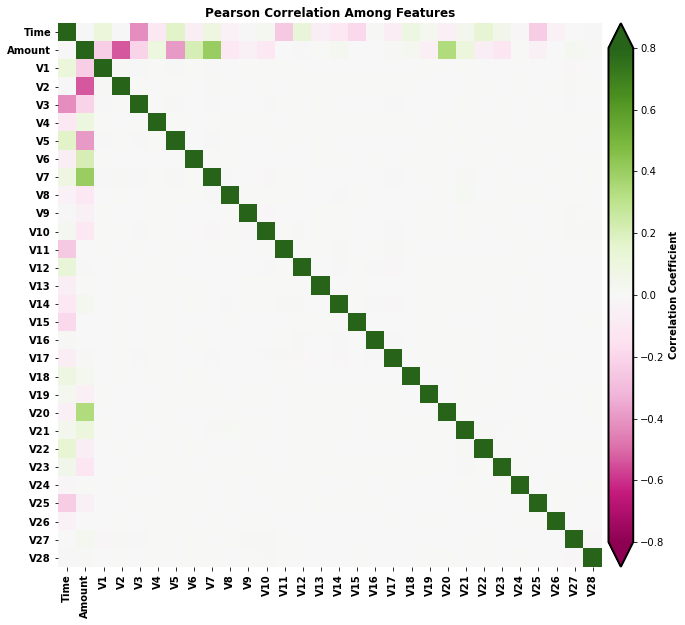

In [9]:
%%time

# Pearson correlation.
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    data=df.drop([target], axis="columns").corr(method="pearson"),
    vmin=-0.80, 
    vmax=0.80, 
    square=True,
    cmap=plt.cm.PiYG,
    cbar_kws={"extend": "both", "pad": 0.01}
)

# Adjustments.
ax.set_xticklabels(ax.get_xticklabels(), weight="bold", rotation="vertical")
ax.set_yticklabels(ax.get_yticklabels(), weight="bold")
ax.collections[0].colorbar.set_label("Correlation Coefficient", weight="bold")
ax.set_title("Pearson Correlation Among Features", weight="bold")
ax.collections[0].colorbar.outline.set_edgecolor("black")
ax.collections[0].colorbar.outline.set_linewidth(2)

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge1.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

CPU times: user 4min 52s, sys: 1.41 s, total: 4min 54s
Wall time: 4min 54s


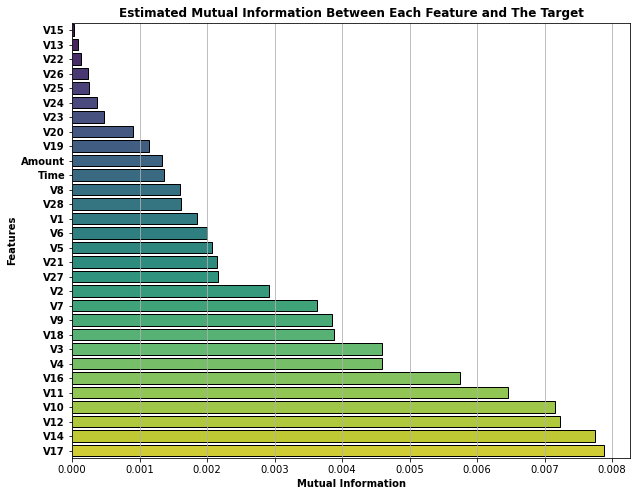

In [10]:
%%time

# Mutual information between continuous features and discrete target.
# These values will be used for feature selection in random forest model.
mi = mutual_info_classif(
    X=df[features],
    y=df[target],
    discrete_features=False
)

# Features in ascending order of mutual information intensity with target.
plt.figure(figsize=(10, 8))
asc_order = mi.argsort()
mi_ordered = pd.Series(data=mi[asc_order], index=features[asc_order])
ax = sns.barplot(
    y=mi_ordered.index, 
    x=mi_ordered.values,
    orient="h",
    palette=sns.color_palette("viridis", n_colors=len(mi_ordered)),
    edgecolor="black"
)

# Adjustments.
ax.set_xlabel("Mutual Information", weight="bold")
ax.set_ylabel("Features", weight="bold")
ax.set_yticklabels(ax.get_yticklabels(), weight="bold")
ax.set_title("Estimated Mutual Information Between Each Feature and The Target", 
             weight="bold")
ax.grid(axis="x")

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge2.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

CPU times: user 10.2 s, sys: 256 ms, total: 10.4 s
Wall time: 10.4 s


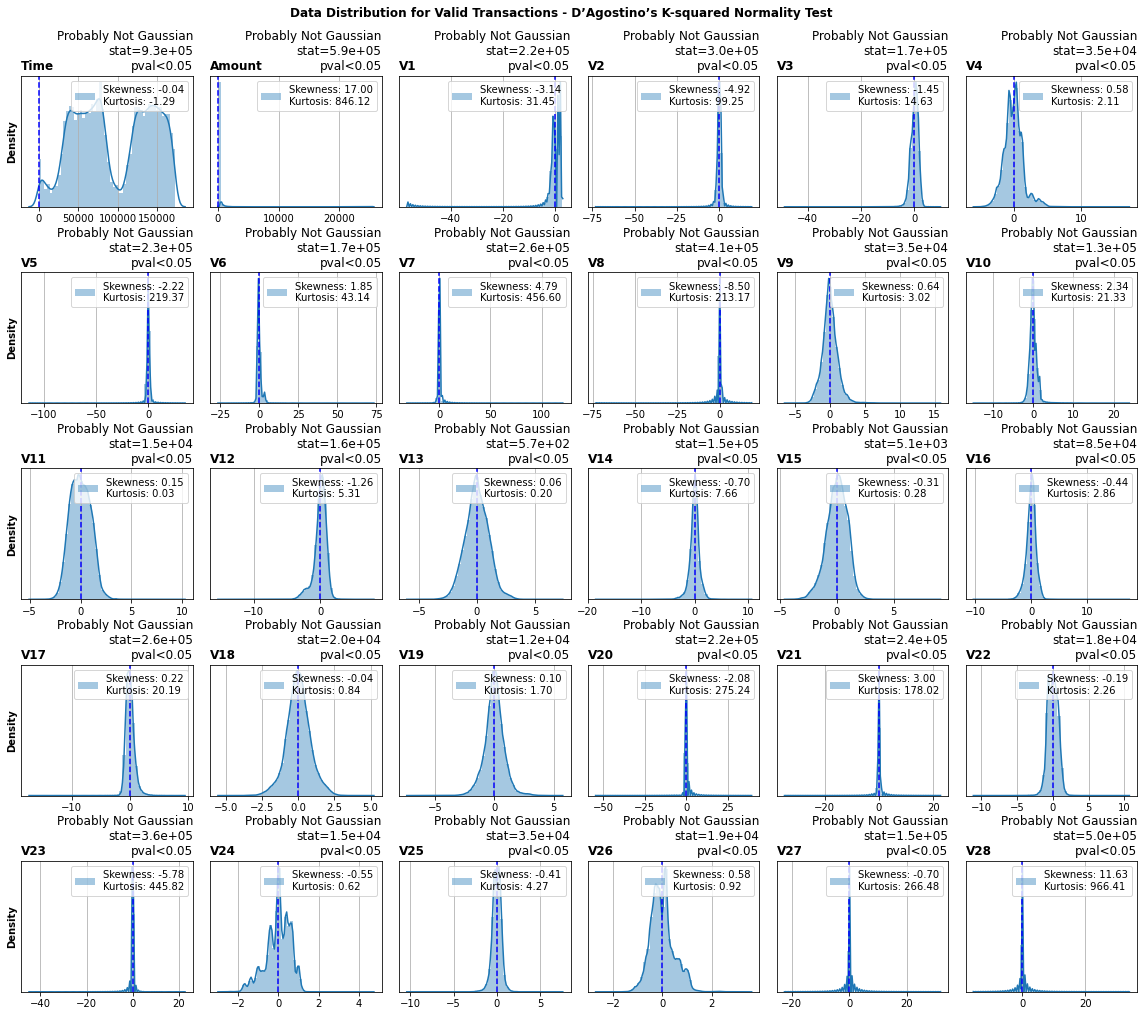

In [11]:
%%time

# Make figure and axes.
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 16))
axes = axes.flatten()

# Only valid transactions.
valid = df[target] == 0
df_tmp = df[valid]

# Plot distribution for each feature.
for axis, feature in zip(axes, features):

    data = df_tmp[feature]
    
    # Skweness and kurtosis for this feature.
    skew = scipy.stats.skew(data)
    kurtosis = scipy.stats.kurtosis(data, fisher=True)
    label = "Skewness: %.2f\nKurtosis: %.2f" %(skew, kurtosis)
    
    plotdata = sns.distplot(
        a=data,
        ax=axis,
        norm_hist=True,
        label=label
    )
    axis.axvline(ls="--", color="blue")    
    
    # Do data have a Gaussian distribution? D’Agostino’s K-squared test.
    statistic, pvalue = scipy.stats.normaltest(df[feature])
    
    if pvalue > 0.05:
        text = "Probably Gaussian\nstat=%.2e\npval>0.05" %(statistic)
    
    else:
        text = "Probably Not Gaussian\nstat=%1.1e\npval<0.05" %(statistic)
    
    # Adjustments. 
    axis.legend(loc="upper right")
    axis.set_yticks([])
    axis.set_title(feature, loc="left", weight="bold")
    axis.set_title(text, loc="right")
    plotdata.set_xlabel(None)
    plotdata.grid()
    
# More adjustments.
axes[0].set_ylabel("Density", weight="bold")
axes[6].set_ylabel("Density", weight="bold")
axes[12].set_ylabel("Density", weight="bold")
axes[18].set_ylabel("Density", weight="bold")
axes[24].set_ylabel("Density", weight="bold")
plt.suptitle("Data Distribution for Valid Transactions - D’Agostino’s K-squared Normality Test",
             weight="bold")
plt.subplots_adjust(wspace=0.10, hspace=0.50, top=0.92)

del data
if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge3.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

CPU times: user 5.94 s, sys: 220 ms, total: 6.16 s
Wall time: 6.19 s


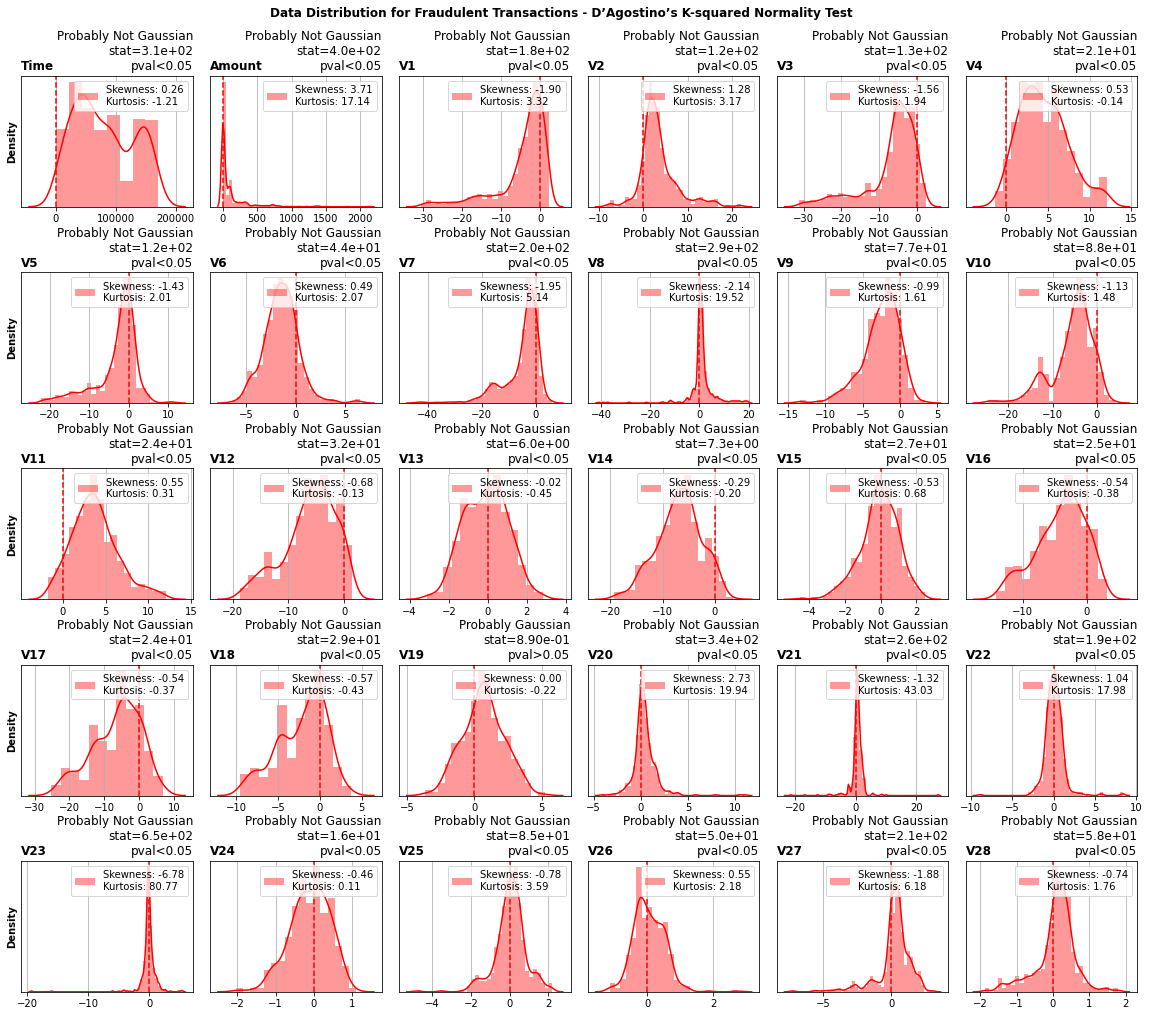

In [12]:
%%time

# Make figure and axes.
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 16))
axes = axes.flatten()

# Only fraudulent transactions.
fraudulent = df[target] == 1
df_tmp = df[fraudulent]

# Plot distribution for each feature.
for axis, feature in zip(axes, features):

    data = df_tmp[feature]
    
    # Skweness and kurtosis for this feature.
    skew = scipy.stats.skew(data)
    kurtosis = scipy.stats.kurtosis(data, fisher=True)
    label = "Skewness: %.2f\nKurtosis: %.2f" %(skew, kurtosis)
    
    plotdata = sns.distplot(
        a=data,
        ax=axis,
        norm_hist=True,
        label=label,
        color="red"
    )
    axis.axvline(ls="--", color="red")   
    
    # Do data have a Gaussian distribution? D’Agostino’s K-squared test.
    statistic, pvalue = scipy.stats.normaltest(df_tmp[feature])
    
    if pvalue > 0.05:
        text = "Probably Gaussian\nstat=%.2e\npval>0.05" %(statistic)
    
    else:
        text = "Probably Not Gaussian\nstat=%1.1e\npval<0.05" %(statistic)
    
    # Adjustments.   
    axis.legend(loc="upper right")
    axis.set_yticks([])
    axis.set_title(feature, loc="left", weight="bold")
    axis.set_title(text, loc="right")
    plotdata.set_xlabel(None)
    plotdata.grid()
    
# More adjustments.
axes[0].set_ylabel("Density", weight="bold")
axes[6].set_ylabel("Density", weight="bold")
axes[12].set_ylabel("Density", weight="bold")
axes[18].set_ylabel("Density", weight="bold")
axes[24].set_ylabel("Density", weight="bold")
plt.suptitle("Data Distribution for Fraudulent Transactions - D’Agostino’s K-squared Normality Test",
             weight="bold")
plt.subplots_adjust(wspace=0.10, hspace=0.50, top=0.92)

del data
if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge4.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

In [13]:
%%time

# Create date time index assuming first time step at 00h00min00sec in day 2013-09-01.
datetime = pd.DatetimeIndex([
    pd.Timestamp("2013-09-01") + pd.Timedelta(seconds, unit="sec") for seconds in df["Time"]
])

CPU times: user 8.86 s, sys: 8 ms, total: 8.87 s
Wall time: 8.88 s


CPU times: user 1.22 s, sys: 164 ms, total: 1.39 s
Wall time: 1.39 s


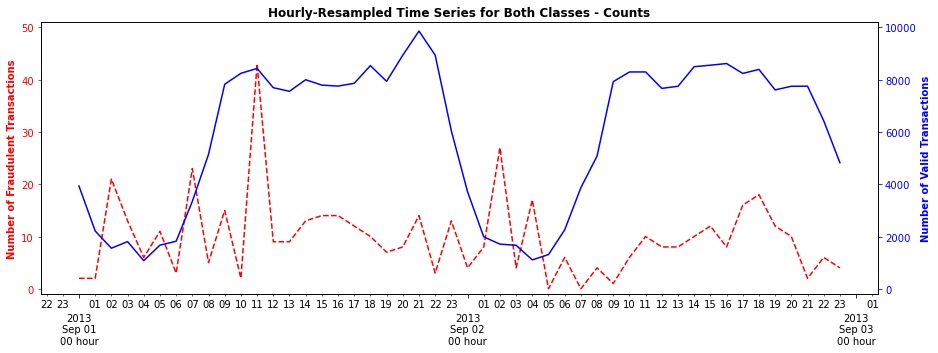

In [14]:
%%time

# Is there a preferential hour when frauds occur?
df_tmp = df.copy()
df_tmp.insert(loc=0, column="DateTime", value=datetime)
plt.figure(figsize=(15, 5))
data = df_tmp[fraudulent].set_index("DateTime")["Class"].resample(rule="1H").count()
plt.plot(data.index, data.values, ls="--", color="red")
axis = plt.gca()

# Are there preferencial hours for valid transactions?
axis2 = axis.twinx()
data = df_tmp[valid].set_index("DateTime")["Class"].resample(rule="1H").count()
axis2.plot(data.index, data.values, color="blue")

# Adjustments.
axis.xaxis.set_major_locator(mdates.DayLocator())
axis.xaxis.set_major_formatter(mdates.DateFormatter("\n%Y\n%b %d\n%H hour"))
axis.xaxis.set_minor_locator(mdates.HourLocator())
axis.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))
axis.set_ylim((-1, 51))
axis2.set_ylim((-200, 10200))
axis.set_ylabel("Number of Fraudulent Transactions", weight="bold")
axis.yaxis.label.set_color("red")
axis.tick_params(axis="y", colors="red")
axis2.set_ylabel("Number of Valid Transactions", weight="bold")
axis2.yaxis.label.set_color("blue")
axis2.tick_params(axis="y", colors="blue")
axis.set_title("Hourly-Resampled Time Series for Both Classes - Counts", weight="bold")

del data
if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge5.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

CPU times: user 1.24 s, sys: 108 ms, total: 1.35 s
Wall time: 1.35 s


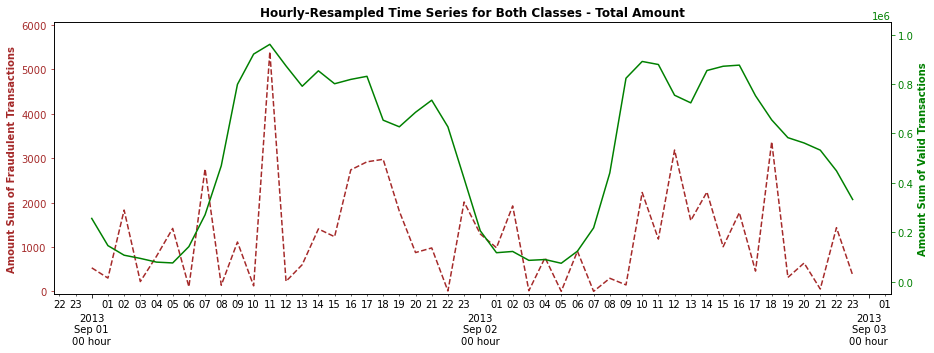

In [15]:
%%time

# Are there amount patterns in fraudulent transactions?
plt.figure(figsize=(15, 5))
data = df_tmp[fraudulent].set_index("DateTime")["Amount"].resample(rule="1H").sum()
plt.plot(data.index, data.values, ls="--", color="brown")
axis = plt.gca()

# Are there amaount patterns for valid transactions?
axis2 = axis.twinx()
data = df_tmp[valid].set_index("DateTime")["Amount"].resample(rule="1H").sum()
axis2.plot(data.index, data.values, color="green")

# Adjustments.
axis.xaxis.set_major_locator(mdates.DayLocator())
axis.xaxis.set_major_formatter(mdates.DateFormatter("\n%Y\n%b %d\n%H hour"))
axis.xaxis.set_minor_locator(mdates.HourLocator())
axis.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))
axis.set_ylim((-60, 6060))
axis2.set_ylim((-0.05e6, 1.05e6))
axis.set_ylabel("Amount Sum of Fraudulent Transactions", weight="bold")
axis.yaxis.label.set_color("brown")
axis.tick_params(axis="y", colors="brown")
axis2.set_ylabel("Amount Sum of Valid Transactions", weight="bold")
axis2.yaxis.label.set_color("green")
axis2.tick_params(axis="y", colors="green")
axis.set_title("Hourly-Resampled Time Series for Both Classes - Total Amount", weight="bold")

del data
if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge6.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

- **Exploratory Data Analysis:**
    - Total of **30** features and **284807** instances. 
    - Most features come from principal components obtained by means of PCA (**V1**, **V2**, ..., **V28**), along with two other original ones: **Time** and **Amount**. 
    - Data show a small number of duplicated instances: **1081** (**~0.38%**).
    - Highly unbalanced data set: **~99.83%** are genuine transactions and **~0.17%** are fraudulent ones. 
    - **V11**, **V10**, **V12**, **V14**, and **V17** they have the highest univariate dependencies with the target, as estimated from mutual information. 
    - Non-Gaussian features. 
    - Create date time index **assuming** first time step at **00h00min00sec** in day **2013-09-01**.
    - The entire data set correspond to **two** days of transactions.
    - Valid transactions have a regular pattern along these two days, that is, a high flat number of transactions in daytime and higher total amount spent at lunch time and then followed by afternoon coffee.
    - Fraudulent transactions occur irregularly over the days, but two episodes draw attention, one at **11 am** in the first day and another at **2 am** in the second day.
    - Due to the size of the available data, which make up just two complete days of transactions, we decided to address the problem without taking into account the temporal ordering of the target and features.  

## Data Split

In [16]:
# Split proportions.
test_size = 0.20
train_size = 1 - test_size

# Total number of instances.
N = df.shape[0]

# Train-test split.
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(
    df.drop(labels=["Time", "Class"], axis="columns"), 
    df["Class"], 
    stratify=df["Class"], 
    test_size=test_size
) 

# Information.
print(">>> Shape and percentual of instances:")
print(f"* Train-Validation:  {df_X_train.shape}; ({df_X_train.shape[0] / N * 100:.2f}%)")
print(f"* Test:              {df_X_test.shape};  ({df_X_test.shape[0] / N * 100:.2f}%)")

# More information.
print("\n>>> Train-Validation target percentages:")
print(df_y_train.value_counts() / df_y_train.size * 100)
print("\n>>> Test target percentages:")
print(df_y_test.value_counts() / df_y_test.size * 100)

>>> Shape and percentual of instances:
* Train-Validation:  (226980, 29); (80.00%)
* Test:              (56746, 29);  (20.00%)

>>> Train-Validation target percentages:
0    99.833466
1     0.166534
Name: Class, dtype: float64

>>> Test target percentages:
0    99.832587
1     0.167413
Name: Class, dtype: float64


- **Data Split:**
    - Stratified random train-validation (**80%**) and test (**20%**) subsets.

## Dummy Classifier (Most Frequent Class)

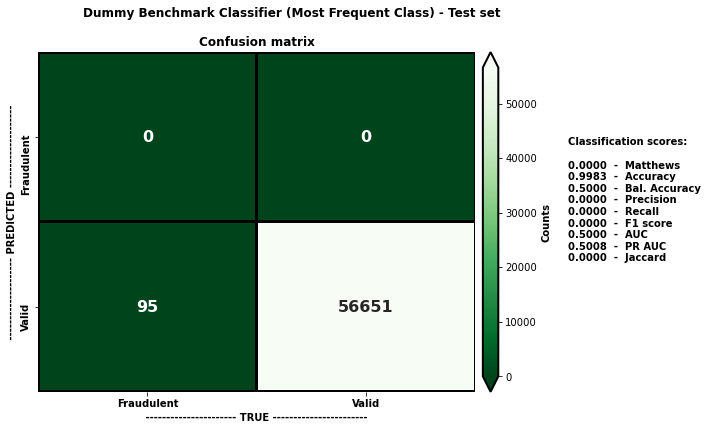

In [17]:
# Used in dictionary with results.
model_code = "dummy"

# Just a benchmark.
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(df_X_train, df_y_train)

# Keep results.
models[model_code] = dummy_classifier
results[model_code] = all_scores(
    model=dummy_classifier, 
    X_true=df_X_test, 
    y_true=df_y_test
)

# Show results for test set.
plot_confusion_matrix(
    model=dummy_classifier, 
    X_true=df_X_test, 
    y_true=df_y_test,
    model_name="Dummy Benchmark Classifier (Most Frequent Class) - Test set"
)

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge7.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

- **Dummy Classifier:**
    - A simple benchmark classifier that votes for most frequent class in training set. 

## Logistic Regression

In [18]:
%%time

# Used in dictionary with results.
model_code = "logreg"

# Input features for this model.
used_features = df_X_train.columns

# Append model to preprocessing pipeline. Now we have a full prediction pipeline.
model = Pipeline(steps=[
        ("scaler", RobustScaler()),
        ("yeo_johnson", PowerTransformer(method="yeo-johnson", standardize=True)),
        ("model", LogisticRegression())
])

# Exhaustive search for the best model.
search = GridSearchCV(
    estimator=model,
    param_grid={"model__C": np.power(10, np.linspace(start=-6, stop=6, num=100))},
    scoring=make_scorer(matthews_corrcoef, greater_is_better=True),
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, shuffle=True),
    verbose=1,
    return_train_score=True
)

# Run fit with all sets of parameters.
_ = search.fit(df_X_train[used_features], df_y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.6min finished


CPU times: user 37.5 s, sys: 2.92 s, total: 40.4 s
Wall time: 4min 47s


In [19]:
# Number of tested models.
n_candidates = len(search.cv_results_["params"])

# Number of used features.
n_features = search.n_features_in_

# Now we have the following results.
print("\n>>> Results for best hyper parameters:")
df_tmp = pd.DataFrame(search.cv_results_)
print(df_tmp.iloc[search.best_index_])

# Optimum hyper parameter set.
print("\n>>> Best hyper parameters:")
print("*", search.best_params_)


>>> Results for best hyper parameters:
mean_fit_time                                  19.6373
std_fit_time                                  0.363449
mean_score_time                               0.345272
std_score_time                               0.0072281
param_model__C                                 10.7227
params                {'model__C': 10.722672220103231}
split0_test_score                             0.733005
split1_test_score                             0.727254
split2_test_score                             0.733949
split3_test_score                             0.763233
split4_test_score                             0.763368
mean_test_score                               0.744162
std_test_score                               0.0157938
rank_test_score                                      1
split0_train_score                            0.746709
split1_train_score                            0.748886
split2_train_score                            0.768234
split3_train_score       

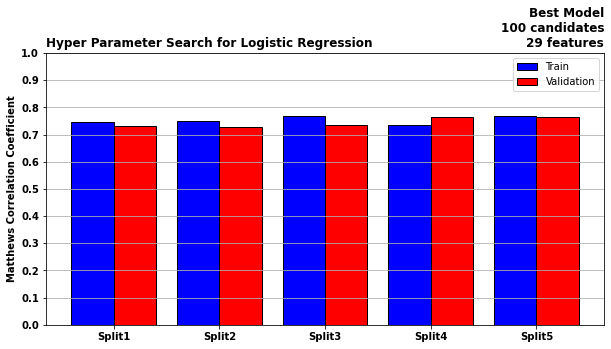

In [20]:
# Train and validation scores for optimum hyper parameter set.
train_cols = [col for col in df_tmp.columns if ("split" in col) and ("train" in col)]
validation_cols = [col for col in df_tmp.columns if ("split" in col) and ("test" in col)]
x = np.arange(1, search.cv.n_splits + 1)
df_tmp = pd.DataFrame(
    data=np.column_stack((
        x,
        df_tmp.iloc[search.best_index_].loc[train_cols], 
        df_tmp.iloc[search.best_index_].loc[validation_cols]
    )),
    columns=["Split", "Train", "Validation"]
)

# Make figure.
plt.figure(figsize=(10, 5))
plt.bar(x - 0.40, df_tmp.Train, width=0.40, color="blue", label="Train", align="edge",
        edgecolor="black")
plt.bar(x, df_tmp.Validation, width=0.40, color="red", label="Validation", align="edge",
        edgecolor="black")
plt.legend()
plt.ylim((0, 1))
plt.yticks(np.arange(0, 1.1, 0.1), weight="bold")
plt.grid(axis="y")
plt.gca().set_xticklabels([""] + ["Split" + str(num) for num in x], weight="bold")
plt.ylabel("Matthews Correlation Coefficient", weight="bold")
plt.title("Hyper Parameter Search for Logistic Regression", weight="bold", loc="left")
plt.title(f"Best Model\n{n_candidates} candidates\n{n_features} features", 
          weight="bold", loc="right")

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge8.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

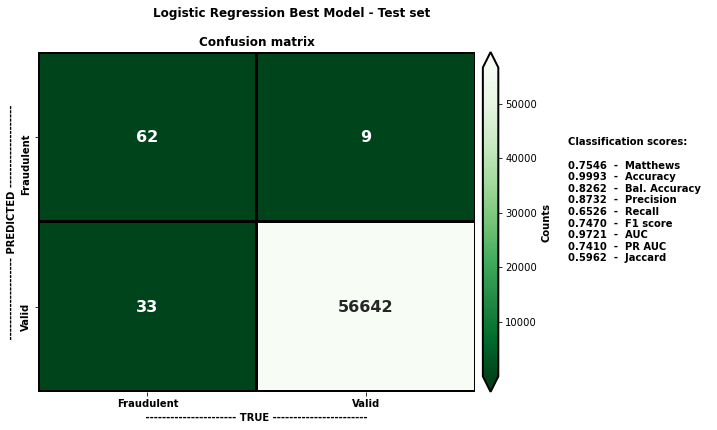

In [21]:
# Keep results.
models[model_code] = search.best_estimator_
results[model_code] = all_scores(
    model=search.best_estimator_, 
    X_true=df_X_test, 
    y_true=df_y_test
)

# Show results for test set.
plot_confusion_matrix(
    model=search.best_estimator_, 
    X_true=df_X_test, 
    y_true=df_y_test,
    model_name="Logistic Regression Best Model - Test set"
)

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge9.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

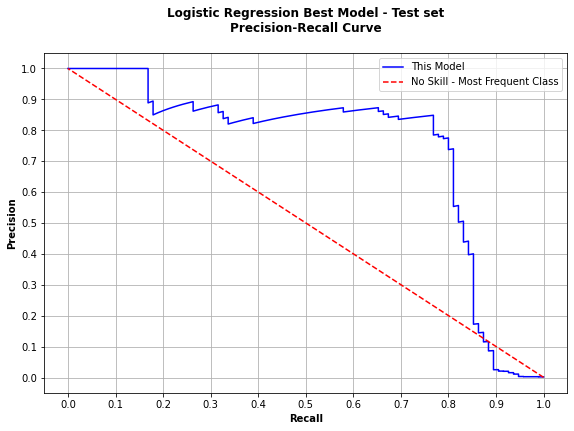

In [22]:
# Show results for test set.
plot_pr_roc(
    model=search.best_estimator_, 
    X_true=df_X_test, 
    y_true=df_y_test,
    model_name="Logistic Regression Best Model - Test set"
)

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge10.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

CPU times: user 4.85 s, sys: 232 ms, total: 5.08 s
Wall time: 12.5 s


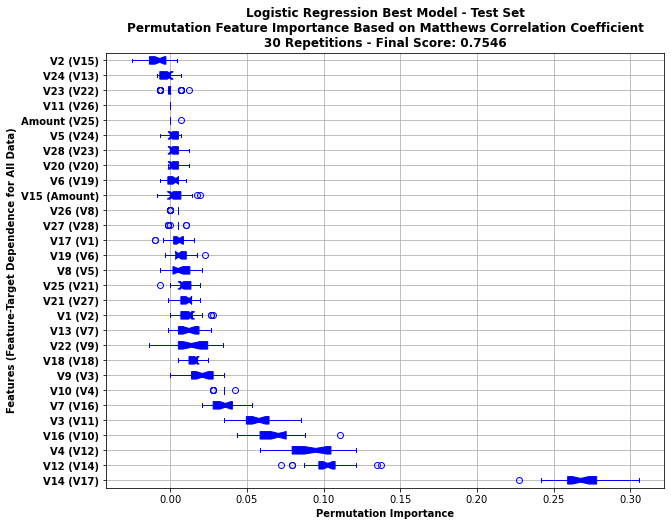

In [23]:
%%time

# Importance of features in test set.
n_repeats = 30
PI = permutation_importance(
    estimator=search.best_estimator_,
    X=df_X_test,
    y=df_y_test,
    scoring=make_scorer(matthews_corrcoef, greater_is_better=True),
    n_repeats=n_repeats,
    n_jobs=-1
)

# Features importances in decreasing order.
order = PI.importances_mean.argsort()[::-1]
PI = PI.importances[order, :]
used_features_ordered = np.array(used_features)[order]

# Make figure.
plt.figure(figsize=(10, 8))
plt.boxplot(
    notch=True,
    x=PI.T,
    vert=False,
    labels=used_features_ordered,
    patch_artist=True,
    boxprops=dict(facecolor="blue", color="blue"),
    capprops=dict(color="blue"),
    whiskerprops=dict(color="blue"),
    flierprops=dict(color="blue", markeredgecolor="blue"),
    medianprops=dict(color="blue")
)

# Adjustments.
ax = plt.gca()
ax.set_xlabel("Permutation Importance", weight="bold")
ax.set_ylabel("Features (Feature-Target Dependence for All Data)", weight="bold")
ax.set_title("Logistic Regression Best Model - Test Set\n" + \
             "Permutation Feature Importance Based on Matthews Correlation Coefficient\n" + \
             f"{n_repeats} Repetitions - Final Score: {results[model_code][0]:.4f}", 
             weight="bold")
ax.grid()
p1 = used_features_ordered
p2 = mi_ordered.index.drop("Time")[::-1]
yticklabels = [v1 + " (" + v2 + ")" for v1, v2 in zip(p1, p2)]
ax.set_yticklabels(yticklabels, weight="bold")

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge11.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

- **Logistic Regression:**
    - Use all available features.
    - Exhaustive hyper parameter search with stratified **5-fold** cross validation using Matthews correlation coefficient for scoring.
    - Preprocessing steps in the pipeline: (1) Robust Scaler and (2) Yeo-Johnson Power Transform.    
    - Search for best hyperparameter for inverse of regularization strength among 100 candidates (**C**).
    - The results for permutation feature importance were as expected, given the previous estimated mutual information between each feature and the target. 

## Decision Tree

In [24]:
%%time

# Used in dictionary with results.
model_code = "dectre"

# Input features for this model.
used_features = df_X_train.columns

# Append model to preprocessing pipeline. Now we have a full prediction pipeline.
model = Pipeline(steps=[
        ("model", DecisionTreeClassifier())
])

# Exhaustive search for the best model.
search = GridSearchCV(
    estimator=model,
    param_grid={
        "model__criterion": ["gini", "entropy"],
        "model__splitter": ["best", "random"],
        "model__max_depth": [3, 4, 5, 6, 7, 10, 50],
        "model__max_features": [int(3), int(15), int(20), int(29)]
    },
    scoring=make_scorer(matthews_corrcoef, greater_is_better=True),
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, shuffle=True),
    verbose=1,
    return_train_score=True
)

# Run fit with all sets of parameters.
_ = search.fit(df_X_train[used_features], df_y_train)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:  1.1min finished


CPU times: user 10.7 s, sys: 1.4 s, total: 12.2 s
Wall time: 1min 11s


In [25]:
# Number of tested models.
n_candidates = len(search.cv_results_["params"])

# Number of used features.
n_features = search.n_features_in_

# Now we have the following results.
print("\n>>> Results for best hyper parameters:")
df_tmp = pd.DataFrame(search.cv_results_)
print(df_tmp.iloc[search.best_index_])

# Optimum hyper parameter set.
print("\n>>> Best hyper parameters:")
print("*", search.best_params_)


>>> Results for best hyper parameters:
mean_fit_time                                                          8.57825
std_fit_time                                                          0.138482
mean_score_time                                                      0.0806247
std_score_time                                                     0.000745517
param_model__criterion                                                 entropy
param_model__max_depth                                                       5
param_model__max_features                                                   20
param_model__splitter                                                     best
params                       {'model__criterion': 'entropy', 'model__max_de...
split0_test_score                                                     0.785264
split1_test_score                                                     0.742571
split2_test_score                                                     0.875222
split3_test_

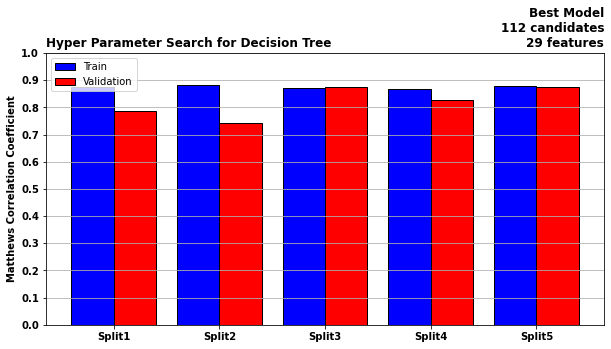

In [26]:
# Train and validation scores for optimum hyper parameter set.
train_cols = [col for col in df_tmp.columns if ("split" in col) and ("train" in col)]
validation_cols = [col for col in df_tmp.columns if ("split" in col) and ("test" in col)]
x = np.arange(1, search.cv.n_splits + 1)
df_tmp = pd.DataFrame(
    data=np.column_stack((
        x,
        df_tmp.iloc[search.best_index_].loc[train_cols], 
        df_tmp.iloc[search.best_index_].loc[validation_cols]
    )),
    columns=["Split", "Train", "Validation"]
)

# Make figure.
plt.figure(figsize=(10, 5))
plt.bar(x - 0.40, df_tmp.Train, width=0.40, color="blue", label="Train", align="edge",
        edgecolor="black")
plt.bar(x, df_tmp.Validation, width=0.40, color="red", label="Validation", align="edge",
        edgecolor="black")
plt.legend()
plt.ylim((0, 1))
plt.yticks(np.arange(0, 1.1, 0.1), weight="bold")
plt.grid(axis="y")
plt.gca().set_xticklabels([""] + ["Split" + str(num) for num in x], weight="bold")
plt.ylabel("Matthews Correlation Coefficient", weight="bold")
plt.title("Hyper Parameter Search for Decision Tree", weight="bold", loc="left")
plt.title(f"Best Model\n{n_candidates} candidates\n{n_features} features", 
          weight="bold", loc="right")

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge12.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

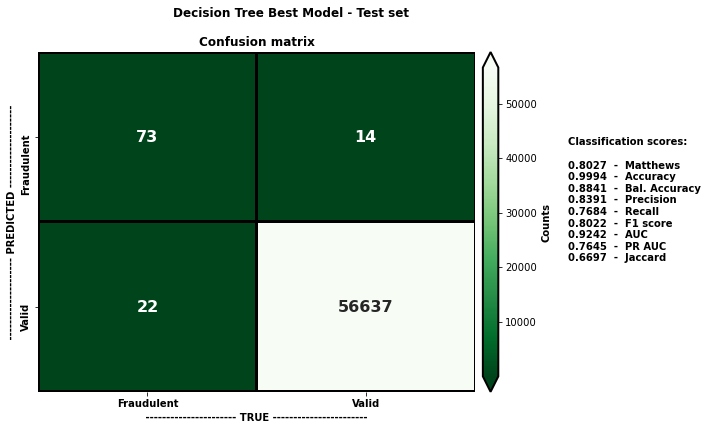

In [27]:
# Keep results.
models[model_code] = search.best_estimator_
results[model_code] = all_scores(
    model=search.best_estimator_, 
    X_true=df_X_test, 
    y_true=df_y_test
)

# Show results for test set.
plot_confusion_matrix(
    model=search.best_estimator_, 
    X_true=df_X_test, 
    y_true=df_y_test,
    model_name="Decision Tree Best Model - Test set"
)

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge13.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

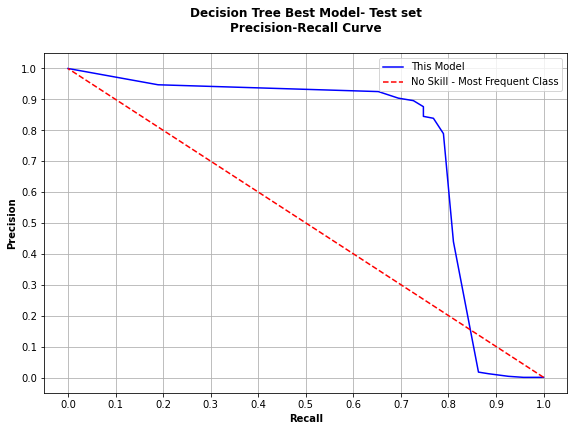

In [28]:
# Show results for test set.
plot_pr_roc(
    model=search.best_estimator_, 
    X_true=df_X_test, 
    y_true=df_y_test,
    model_name="Decision Tree Best Model- Test set"
)

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge14.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

CPU times: user 992 ms, sys: 152 ms, total: 1.14 s
Wall time: 4.07 s


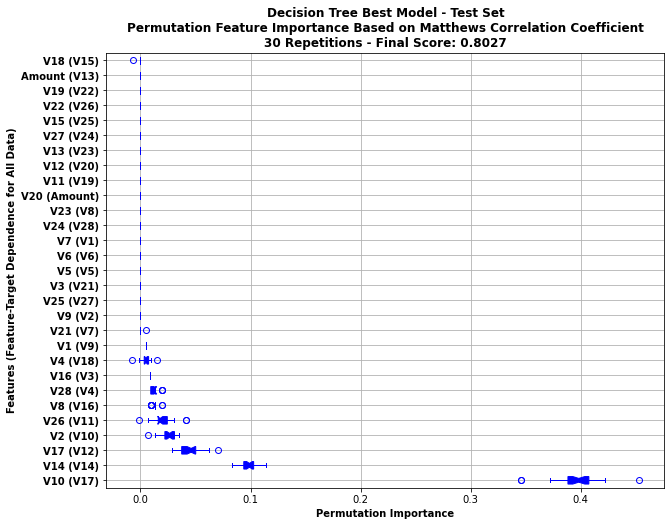

In [29]:
%%time

# Importance of features in test set.
n_repeats = 30
PI = permutation_importance(
    estimator=search.best_estimator_,
    X=df_X_test,
    y=df_y_test,
    scoring=make_scorer(matthews_corrcoef, greater_is_better=True),
    n_repeats=n_repeats,
    n_jobs=-1
)

# Features importances in decreasing order.
order = PI.importances_mean.argsort()[::-1]
PI = PI.importances[order, :]
used_features_ordered = np.array(used_features)[order]

# Make figure.
plt.figure(figsize=(10, 8))
plt.boxplot(
    notch=True,
    x=PI.T,
    vert=False,
    labels=used_features_ordered,
    patch_artist=True,
    boxprops=dict(facecolor="blue", color="blue"),
    capprops=dict(color="blue"),
    whiskerprops=dict(color="blue"),
    flierprops=dict(color="blue", markeredgecolor="blue"),
    medianprops=dict(color="blue")
)

# Adjustments.
ax = plt.gca()
ax.set_xlabel("Permutation Importance", weight="bold")
ax.set_ylabel("Features (Feature-Target Dependence for All Data)", weight="bold")
ax.set_title("Decision Tree Best Model - Test Set\n" + \
             "Permutation Feature Importance Based on Matthews Correlation Coefficient\n" + \
             f"{n_repeats} Repetitions - Final Score: {results[model_code][0]:.4f}", 
             weight="bold")
ax.grid()
p1 = used_features_ordered
p2 = mi_ordered.index.drop("Time")[::-1]
yticklabels = [v1 + " (" + v2 + ")" for v1, v2 in zip(p1, p2)]
ax.set_yticklabels(yticklabels, weight="bold")

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge15.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

- **Decision Tree:**
    - Use all available features.
    - Exhaustive hyper parameter search with stratified **5-fold** cross validation using Matthews correlation coefficient for scoring.
    - Without preprocessing steps in the pipeline.    
    - Search for the best hyperparameter set among 112 candidates, varying the function to measure the quality of a split (**criterion**), the strategy used to choose the split at each node (**splitter**), maximum depth of the tree (**max_depth**), and the number of features to consider when looking for the best split (**max_features**).
    - Most of the results for permutation feature importance were as expected, given the previous estimated mutual information between each feature and the target.

## XGBoost Classifier

In [30]:
%%time

# Used in dictionary with results.
model_code = "xgboos"

# Best decision tree previously found.
# {'model__criterion': 'entropy', 
#  'model__max_depth': 5, 
#  'model__max_features': 29, 
#  'model__splitter': 'best'}

# Input features for this model.
used_features = ["V26", "V27", "V21", "V8", "V7", "V16", "V17", "V10", "V14"]

# Append model to preprocessing pipeline. Now we have a full prediction pipeline.
model = Pipeline(steps=[
        ("model", XGBClassifier())
])

# Exhaustive search for the best model.
search = GridSearchCV(
    estimator=model,
    param_grid={
        "model__n_estimators": [100, 200],
        "model__max_depth":[5],
        "model__scale_pos_weight": [100, 600],
        "model__learning_rate": [0.075, 0.10],
        "model__reg_alpha": [0.1, 1],
        "model__reg_lambda": [0.1, 1]
    },
    scoring=make_scorer(matthews_corrcoef, greater_is_better=True),
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, shuffle=True),
    verbose=1,
    return_train_score=True
)

# Run fit with all sets of parameters.
_ = search.fit(df_X_train[used_features], df_y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  6.3min finished


CPU times: user 8min 40s, sys: 14 s, total: 8min 54s
Wall time: 6min 32s


In [31]:
# Number of tested models.
n_candidates = len(search.cv_results_["params"])

# Number of used features.
n_features = search.n_features_in_

# Now we have the following results.
print("\n>>> Results for best hyper parameters:")
df_tmp = pd.DataFrame(search.cv_results_)
print(df_tmp.iloc[search.best_index_])

# Optimum hyper parameter set.
print("\n>>> Best hyper parameters:")
print("*", search.best_params_)


>>> Results for best hyper parameters:
mean_fit_time                                                              119.596
std_fit_time                                                              0.778352
mean_score_time                                                           0.429311
std_score_time                                                          0.00934903
param_model__learning_rate                                                     0.1
param_model__max_depth                                                           5
param_model__n_estimators                                                      200
param_model__reg_alpha                                                           1
param_model__reg_lambda                                                        0.1
param_model__scale_pos_weight                                                  100
params                           {'model__learning_rate': 0.1, 'model__max_dept...
split0_test_score                              

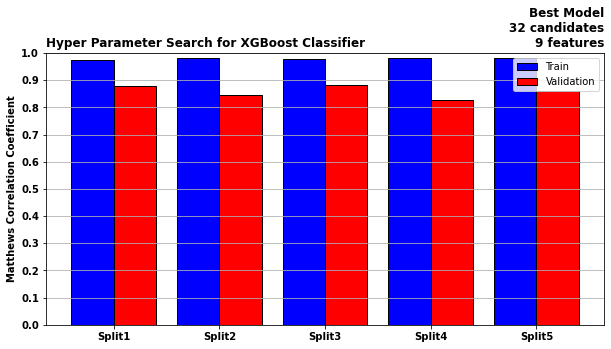

In [32]:
# Train and validation scores for optimum hyper parameter set.
train_cols = [col for col in df_tmp.columns if ("split" in col) and ("train" in col)]
validation_cols = [col for col in df_tmp.columns if ("split" in col) and ("test" in col)]
x = np.arange(1, search.cv.n_splits + 1)
df_tmp = pd.DataFrame(
    data=np.column_stack((
        x,
        df_tmp.iloc[search.best_index_].loc[train_cols], 
        df_tmp.iloc[search.best_index_].loc[validation_cols]
    )),
    columns=["Split", "Train", "Validation"]
)

# Make figure.
plt.figure(figsize=(10, 5))
plt.bar(x - 0.40, df_tmp.Train, width=0.40, color="blue", label="Train", align="edge",
        edgecolor="black")
plt.bar(x, df_tmp.Validation, width=0.40, color="red", label="Validation", align="edge",
        edgecolor="black")
plt.legend()
plt.ylim((0, 1))
plt.yticks(np.arange(0, 1.1, 0.1), weight="bold")
plt.grid(axis="y")
plt.gca().set_xticklabels([""] + ["Split" + str(num) for num in x], weight="bold")
plt.ylabel("Matthews Correlation Coefficient", weight="bold")
plt.title("Hyper Parameter Search for XGBoost Classifier", weight="bold", loc="left")
plt.title(f"Best Model\n{n_candidates} candidates\n{n_features} features", 
          weight="bold", loc="right")

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge16.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

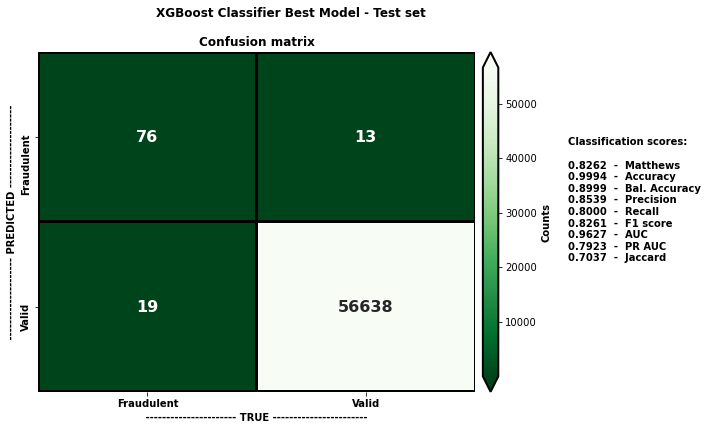

In [33]:
# Keep results.
models[model_code] = search.best_estimator_
results[model_code] = all_scores(
    model=search.best_estimator_, 
    X_true=df_X_test[used_features], 
    y_true=df_y_test
)

# Show results for test set.
plot_confusion_matrix(
    model=search.best_estimator_, 
    X_true=df_X_test[used_features], 
    y_true=df_y_test,
    model_name="XGBoost Classifier Best Model - Test set"
)

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge17.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

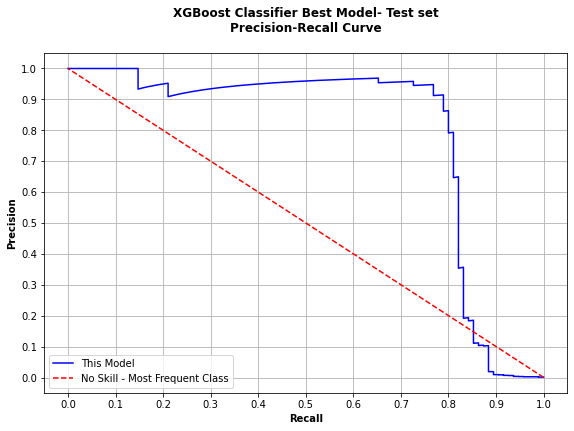

In [34]:
# Show results for test set.
plot_pr_roc(
    model=search.best_estimator_, 
    X_true=df_X_test[used_features], 
    y_true=df_y_test,
    model_name="XGBoost Classifier Best Model- Test set"
)

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge18.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

CPU times: user 8.74 s, sys: 320 ms, total: 9.06 s
Wall time: 17.2 s


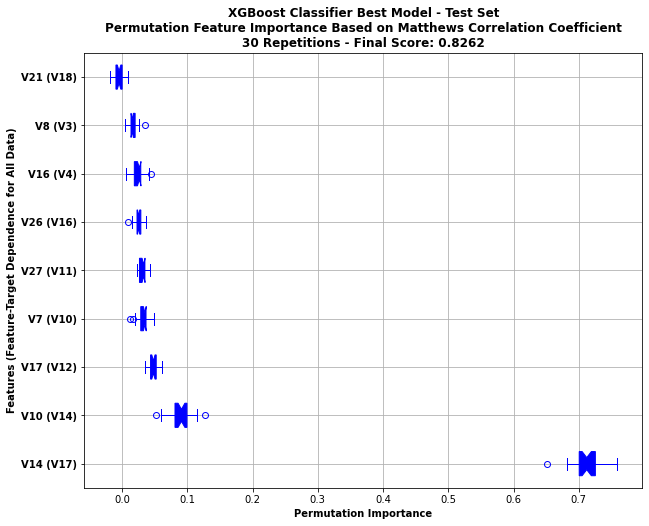

In [35]:
%%time

# Importance of features in test set.
n_repeats = 30
PI = permutation_importance(
    estimator=search.best_estimator_,
    X=df_X_test[used_features],
    y=df_y_test,
    scoring=make_scorer(matthews_corrcoef, greater_is_better=True),
    n_repeats=n_repeats,
    n_jobs=-1
)

# Features importances in decreasing order.
order = PI.importances_mean.argsort()[::-1]
PI = PI.importances[order, :]
used_features_ordered = np.array(used_features)[order]

# Make figure.
plt.figure(figsize=(10, 8))
plt.boxplot(
    notch=True,
    x=PI.T,
    vert=False,
    labels=used_features_ordered,
    patch_artist=True,
    boxprops=dict(facecolor="blue", color="blue"),
    capprops=dict(color="blue"),
    whiskerprops=dict(color="blue"),
    flierprops=dict(color="blue", markeredgecolor="blue"),
    medianprops=dict(color="blue")
)

# Adjustments.
ax = plt.gca()
ax.set_xlabel("Permutation Importance", weight="bold")
ax.set_ylabel("Features (Feature-Target Dependence for All Data)", weight="bold")
ax.set_title("XGBoost Classifier Best Model - Test Set\n" + \
             "Permutation Feature Importance Based on Matthews Correlation Coefficient\n" + \
             f"{n_repeats} Repetitions - Final Score: {results[model_code][0]:.4f}", 
             weight="bold")
ax.grid()
p1 = used_features_ordered
p2 = mi_ordered.index.drop("Time")[::-1]
yticklabels = [v1 + " (" + v2 + ")" for v1, v2 in zip(p1, p2)]
ax.set_yticklabels(yticklabels, weight="bold")

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge19.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

- **XGBoost Classifier:**
    - Use the **9** most important features according to the previous decision tree model: **V26**, **V27**, **V21**, **V8**, **V7**, **V16**, **V17**, **V10**, and **V14**
    - Exhaustive hyper parameter search with stratified **5-fold** cross validation using Matthews correlation coefficient for scoring.
    - Without preprocessing steps in the pipeline.    
    - Search for the best hyperparameter set among **32** candidates, varying the number of boosting rounds (**n_estimators**), balancing of positive and negative weights (**scale_pos_weight**), boosting learning rate (**learning_rate**), L1 regularization term on weights (**reg_alpha**), and L2 regularization term on weights (**reg_lambda**).
    - Most of the results for permutation feature importance were as expected, given the previous estimated mutual information between each feature and the target.

## Random Forest

In [36]:
%%time

# Used in dictionary with results.
model_code = "ranfor"

# Best decision tree previously found.
# {'model__criterion': 'entropy', 
#  'model__max_depth': 5, 
#  'model__max_features': 29, 
#  'model__splitter': 'best'}

# Input features for this model.
used_features = ["V26", "V27", "V21", "V8", "V7", "V16", "V17", "V10", "V14"]

# Append model to preprocessing pipeline. Now we have a full prediction pipeline.
model = Pipeline(steps=[
        ("model", XGBRFClassifier())
])

# Exhaustive search for the best model.
search = GridSearchCV(
    estimator=model,
    param_grid={
        "model__n_estimators": [100, 200],
        "model__max_depth":[5],
        "model__scale_pos_weight": [100, 600],
        "model__learning_rate": [0.075, 0.10],
        "model__reg_alpha": [0.1, 1],
        "model__reg_lambda": [0.1, 1]
    },
    scoring=make_scorer(matthews_corrcoef, greater_is_better=True),
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, shuffle=True),
    verbose=1,
    return_train_score=True
)

# Run fit with all sets of parameters.
_ = search.fit(df_X_train[used_features], df_y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  4.5min finished


CPU times: user 7min 41s, sys: 13.3 s, total: 7min 55s
Wall time: 4min 40s


In [37]:
# Number of tested models.
n_candidates = len(search.cv_results_["params"])

# Number of used features.
n_features = search.n_features_in_

# Now we have the following results.
print("\n>>> Results for best hyper parameters:")
df_tmp = pd.DataFrame(search.cv_results_)
print(df_tmp.iloc[search.best_index_])

# Optimum hyper parameter set.
print("\n>>> Best hyper parameters:")
print("*", search.best_params_)


>>> Results for best hyper parameters:
mean_fit_time                                                              80.7846
std_fit_time                                                               5.51062
mean_score_time                                                           0.505527
std_score_time                                                            0.018315
param_model__learning_rate                                                   0.075
param_model__max_depth                                                           5
param_model__n_estimators                                                      200
param_model__reg_alpha                                                         0.1
param_model__reg_lambda                                                        0.1
param_model__scale_pos_weight                                                  100
params                           {'model__learning_rate': 0.075, 'model__max_de...
split0_test_score                              

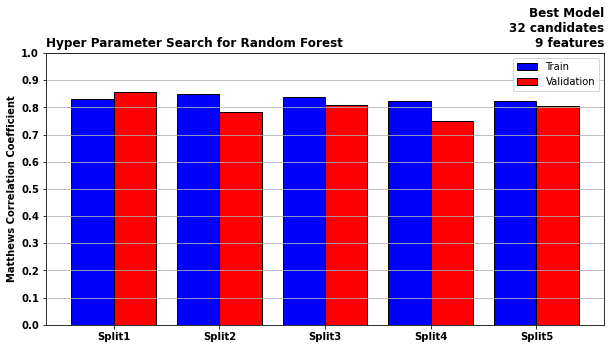

In [38]:
# Train and validation scores for optimum hyper parameter set.
train_cols = [col for col in df_tmp.columns if ("split" in col) and ("train" in col)]
validation_cols = [col for col in df_tmp.columns if ("split" in col) and ("test" in col)]
x = np.arange(1, search.cv.n_splits + 1)
df_tmp = pd.DataFrame(
    data=np.column_stack((
        x,
        df_tmp.iloc[search.best_index_].loc[train_cols], 
        df_tmp.iloc[search.best_index_].loc[validation_cols]
    )),
    columns=["Split", "Train", "Validation"]
)

# Make figure.
plt.figure(figsize=(10, 5))
plt.bar(x - 0.40, df_tmp.Train, width=0.40, color="blue", label="Train", align="edge",
        edgecolor="black")
plt.bar(x, df_tmp.Validation, width=0.40, color="red", label="Validation", align="edge",
        edgecolor="black")
plt.legend()
plt.ylim((0, 1))
plt.yticks(np.arange(0, 1.1, 0.1), weight="bold")
plt.grid(axis="y")
plt.gca().set_xticklabels([""] + ["Split" + str(num) for num in x], weight="bold")
plt.ylabel("Matthews Correlation Coefficient", weight="bold")
plt.title("Hyper Parameter Search for Random Forest", weight="bold", loc="left")
plt.title(f"Best Model\n{n_candidates} candidates\n{n_features} features", 
          weight="bold", loc="right")

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge20.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

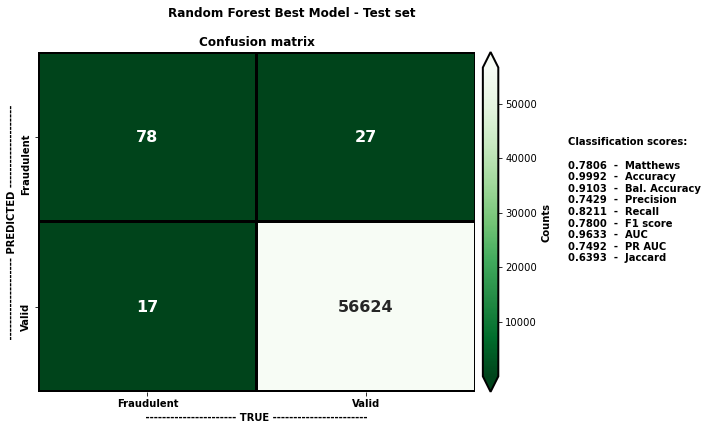

In [39]:
# Keep results.
models[model_code] = search.best_estimator_
results[model_code] = all_scores(
    model=search.best_estimator_, 
    X_true=df_X_test[used_features], 
    y_true=df_y_test
)

# Show results for test set.
plot_confusion_matrix(
    model=search.best_estimator_, 
    X_true=df_X_test[used_features], 
    y_true=df_y_test,
    model_name="Random Forest Best Model - Test set"
)

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge21.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

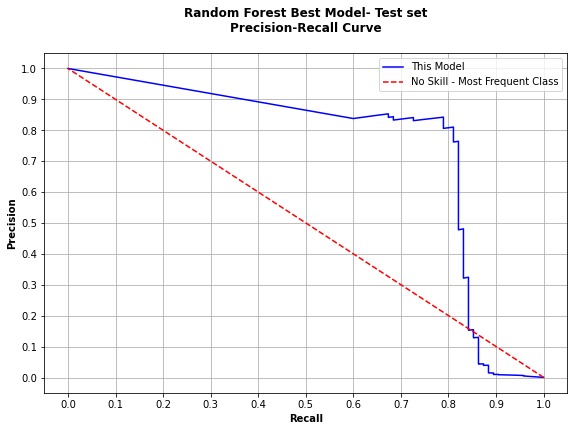

In [40]:
# Show results for test set.
plot_pr_roc(
    model=search.best_estimator_, 
    X_true=df_X_test[used_features], 
    y_true=df_y_test,
    model_name="Random Forest Best Model- Test set"
)

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge22.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

CPU times: user 8.62 s, sys: 316 ms, total: 8.94 s
Wall time: 13.2 s


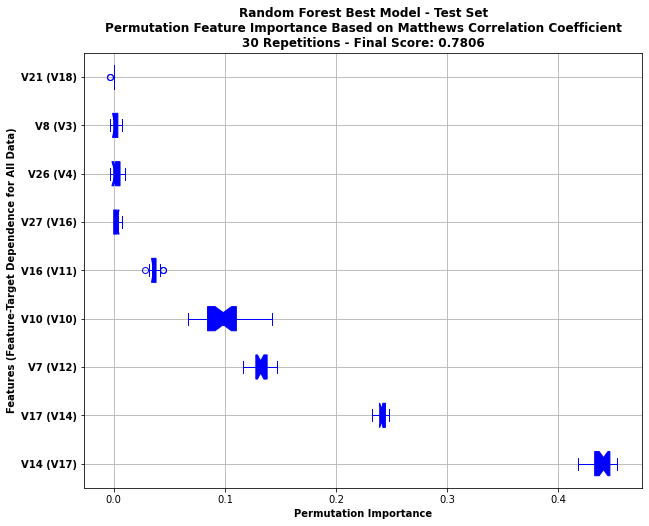

In [41]:
%%time

# Importance of features in test set.
n_repeats = 30
PI = permutation_importance(
    estimator=search.best_estimator_,
    X=df_X_test[used_features],
    y=df_y_test,
    scoring=make_scorer(matthews_corrcoef, greater_is_better=True),
    n_repeats=n_repeats,
    n_jobs=-1
)

# Features importances in decreasing order.
order = PI.importances_mean.argsort()[::-1]
PI = PI.importances[order, :]
used_features_ordered = np.array(used_features)[order]

# Make figure.
plt.figure(figsize=(10, 8))
plt.boxplot(
    notch=True,
    x=PI.T,
    vert=False,
    labels=used_features_ordered,
    patch_artist=True,
    boxprops=dict(facecolor="blue", color="blue"),
    capprops=dict(color="blue"),
    whiskerprops=dict(color="blue"),
    flierprops=dict(color="blue", markeredgecolor="blue"),
    medianprops=dict(color="blue")
)

# Adjustments.
ax = plt.gca()
ax.set_xlabel("Permutation Importance", weight="bold")
ax.set_ylabel("Features (Feature-Target Dependence for All Data)", weight="bold")
ax.set_title("Random Forest Best Model - Test Set\n" + \
             "Permutation Feature Importance Based on Matthews Correlation Coefficient\n" + \
             f"{n_repeats} Repetitions - Final Score: {results[model_code][0]:.4f}", 
             weight="bold")
ax.grid()
p1 = used_features_ordered
p2 = mi_ordered.index.drop("Time")[::-1]
yticklabels = [v1 + " (" + v2 + ")" for v1, v2 in zip(p1, p2)]
ax.set_yticklabels(yticklabels, weight="bold")

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge23.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )  

- **Random Forest:**
    - The same configuration as the XGBoost Classifier model.

## Conclusions

In [42]:
%%time

# Head of table with all results.
final_table = PrettyTable(
    field_names=[
        "Tuned Model", 
        "Matt.",
        "Acc.",
        "Bal. Acc.",
        "Precision",
        "Recall",
        "F1 Score",
        "AUC",
        "PR AUC",
        "Jaccard"
    ], 
    title="Overall Performances of Machine Learning Models on Test Data"
)
final_table.align = "l"

# Fill this table with performances of trained models.
final_table.add_row(
    ["Dummy Classifier"] + \
    ["%.4f" %(m) for m in results["dummy"]]
)
final_table.add_row(
    ["Logistic Regression"] + \
    ["%.4f" %(m) for m in results["logreg"]]
)
final_table.add_row(
    ["Decision Tree"] + \
    ["%.4f" %(m) for m in results["dectre"]]
)
final_table.add_row(
    ["XGBoost Classifier"] + \
    ["%.4f" %(m) for m in results["xgboos"]]
)
final_table.add_row(
    ["Random Forest"] + \
    ["%.4f" %(m) for m in results["ranfor"]]
)

print(final_table)

+---------------------------------------------------------------------------------------------------------------+
|                          Overall Performances of Machine Learning Models on Test Data                         |
+---------------------+--------+--------+-----------+-----------+--------+----------+--------+--------+---------+
| Tuned Model         | Matt.  | Acc.   | Bal. Acc. | Precision | Recall | F1 Score | AUC    | PR AUC | Jaccard |
+---------------------+--------+--------+-----------+-----------+--------+----------+--------+--------+---------+
| Dummy Classifier    | 0.0000 | 0.9983 | 0.5000    | 0.0000    | 0.0000 | 0.0000   | 0.5000 | 0.5008 | 0.0000  |
| Logistic Regression | 0.7546 | 0.9993 | 0.8262    | 0.8732    | 0.6526 | 0.7470   | 0.9721 | 0.7410 | 0.5962  |
| Decision Tree       | 0.8027 | 0.9994 | 0.8841    | 0.8391    | 0.7684 | 0.8022   | 0.9242 | 0.7645 | 0.6697  |
| XGBoost Classifier  | 0.8262 | 0.9994 | 0.8999    | 0.8539    | 0.8000 | 0.8261   | 0.

- **Conclusions:**
    - Due to the comparatively small data size (only two days), we did not approach the task for credit card fraud detection as a time series forecasting problem, so that we were able to use cross validation without temporal blocking.
    - We test **five** machine learning models: (1) a benchmark dummy classifier that votes for the most frequent class, (2) logistic regression, (3) decision tree, (4) XGBoost classifier, and (5) Random Forest.
    - All models take about the same time to to be trained (**1 - 6 min**) on a machine with **64GB RAM** and **40 cores**.
    - Compare these models using the following classification metrics: (1) Matthews correlation coefficient, (2) accuracy, (3) balanced accuracy, (4) precision, (5) recall, (6) F1 score, (7) area under the ROC curve and, (8) area under the precision-recall curve, and (9) Jaccard score.
    - The overall performance of tree-based models are better than the logistic regression's one. Decision tree and boosting had the best scoring metrics on test data set among all models, and the latter was slightly better. Thus, our best-of-all model is **XGBoost Classifier**.
    - According to the Kaggle recommendation of using Area Under the ROC Curve (**AUC**) to evaluate models, we could see that **our best models had similar or even better performances** of AUC score on test data set when compared to some public available solutions uploaded on Kaggle's platform. 
    - Future work suggestions: Boosting with Bayesian hyper parameter search, or neural networks. 